In [1]:
import torch
from interpretability.task_modeling.task_env.task_env import RandomTargetDelay
from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle

/home/csverst/miniconda3/envs/build5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Effector builds the musculoskeletal model, including the muscles and the skeleton.
This model uses Mujoco muscles

In [2]:

effector = RigidTendonArm26(muscle= MujocoHillMuscle()) 

The Environment takes in the effector and implements the task logic that the musculoskeletal model will try to solve.

In [3]:
task = RandomTargetDelay(effector, max_ep_duration= 2.0)

All environments should have a "generate_dataset" method that returns a dictionary of torch tensors for training

In [4]:
dataset_dict = task.generate_dataset(100)

In [5]:
# The fields of the datasets are:
print(dataset_dict.keys())
ics = dataset_dict['ics'] # initial conditions of the trials to train on
inputs = dataset_dict['inputs'] # inputs to the RNN (from external to the environment, e.g. new goal, etc.)
targets = dataset_dict['targets'] # The values that the output of the RNN should try to match
conds = dataset_dict['conds'] # The conditions of the trials (for samplers that need to know the conditions of the trials, e.g. the delay time, etc.)
extra = dataset_dict['extra'] # Extra information that might be needed for training (e.g. delay time, trial_length etc.)


dict_keys(['ics', 'inputs', 'targets', 'conds', 'extra'])


To make your own environment, there are a few things that you need to figure out:
1. What musculoskeletal model to use:
    - I recommend sticking with the existing models, as musculoskeletal geometry can be tricky
    - Mujoco Muscles are also nice and fast, so I'd recommend them as your muscle type.
2. What your loss function should be
    - The loss function from RandomTargetDelay is shown here.
3. What task you'd like the model to perform:
    - The task logic must be reflected in the dataset dict above


Probably the easiest way to explain it is to show the training_step and forward() methods of the task_wrapper class, which handles the logic of the interactions between the RNN and the MotorNet environment

In [6]:
""" 
This is the training step of the model. The model is a RNN that takes as input the initial conditions of the trials, 
the inputs to the RNN, and the conditions of the trials. Note the similarity to the dataset_dict above.
The output of the RNN is compared to the targets of the trials and the loss is computed. 
"""
def training_step(self, batch, batch_ix):
    # Get the batch data
    ics = batch[0]
    inputs = batch[1]
    targets = batch[2]
    conds = batch[4]
    extras = batch[5]

    """ The training step passes the batch through the model, which returns an "output_dict" with the outputs of the model."""
    # Pass data through the model
    output_dict = self.forward(ics, inputs, targets)

    """ 
    We construct a "loss_dict" that contains all the information potentially needed to compute the loss.
    "controlled" is the variable that the model is trying to control (e.g. the effector position, etc.)
    "actions" are the actions that the model is taking to control the "controlled" variable (e.g. the muscle activations, etc.)
    "targets" are the values that the "controlled" variable should try to match
    "inputs" are the inputs to the model (e.g., the targets that model sees, the go cue etc.)
    "conds" are the conditions of the trials (e.g. the delay time, the trial length etc.)
    "extra" is extra information that might be needed for computing the loss (e.g. the delay time, the trial length etc.)
    
    """
    loss_dict = {
        "controlled": output_dict["controlled"],
        "actions": output_dict["actions"],
        "targets": targets,
        "inputs": inputs,
        "conds": conds,
        "extra": extras,
    }

    # Compute the loss using the loss function object
    loss_all = self.loss_func(loss_dict)
    self.log("train/loss", loss_all)
    return loss_all

Here is the loss function that the RandomTarget task uses.

Notice that it seeks to minimize the weighted combination of: 
- MSE from "controlled" (hand position) vs target 
- the actions (muscle activations).

In [7]:
import torch.nn as nn
class LossFunc:
    def __init__():
        pass

    def __call__(self, pred, target, act=None):
        pass


class RandomTargetLoss(LossFunc):
    def __init__(self, position_loss, pos_weight, act_weight):
        self.position_loss = position_loss
        self.action_loss = nn.MSELoss()
        self.pos_weight = pos_weight
        self.act_weight = act_weight

    def __call__(self, loss_dict):
        pred = loss_dict["controlled"]
        target = loss_dict["targets"]
        act = loss_dict["actions"]
        # inputs = loss_dict["inputs"]
        # TODO: torch.clip
        pos_loss = self.pos_weight * self.position_loss(pred, target)
        act_loss = self.act_weight * self.action_loss(act, torch.zeros_like(act))
        return pos_loss + act_loss

Finally, I'm showing the forward method of the task_wrapper class.
This shouldn't need to change, but understanding it may make your life easier in the long run.

Importantly, note:
- The difference betweeen inputs  and env_states
-- Inputs are the "external" inputs to the model, such as if the goal changes or the go-cue is given
-- env_states are the "inputs" to the RNN that come from the MotorNet environment itself

In general, contextual information should be in inputs, while things to do with the musculoskeletal model should be in env_states

In [8]:
def forward(self, ics, inputs, targets=None):
    """Pass data through the model
    args:
        ics (torch.Tensor):
            The initial conditions for the environment
        inputs (torch.Tensor):
            The inputs to the model
        targets (torch.Tensor):
            The targets for the model
            (i.e., the outputs of the environment or MotorNet goal)

    """
    batch_size = ics.shape[0]

    # If we are in a coupled environment, set the environment state
    if self.task_env.coupled_env:
        options = {"ic_state": ics, "target_state": targets[:, 0, :]}
        env_states, info = self.task_env.reset(
            batch_size=batch_size, options=options
        )
        env_state_list = []
    else:
        env_states = None
        env_state_list = None

    # If the model has specialized initializations, call them
    if hasattr(self.model, "init_hidden"):
        hidden = self.model.init_hidden(batch_size=batch_size).to(self.device)
    else:
        hidden = torch.zeros(batch_size, self.latent_size).to(self.device)

    # Latents are the hidden states of the model
    latents = []

    # Controlled is what the model is attempting to control
    # (i.e., hand position for MotorNet)
    # or the readout output for decoupled environments
    controlled = []

    # Actions are the the model output themselves
    # (i.e., the motor commands for MotorNet)
    # or the readout output for decoupled environments
    # NOTE: for decoupled environments, actions and controlled are the same
    actions = []

    count = 0
    terminated = False
    while not terminated and len(controlled) < self.task_env.n_timesteps:

        # Get the appropriate model input for coupled and decoupled envs
        if self.task_env.coupled_env:
            # If we are in a coupled environment,
            # both the environment state
            # and the external inputs are fed into the model
            model_input = torch.hstack((env_states, inputs[:, count, :]))
        else:
            # If we are in a decoupled environment,
            # only the external inputs are fed into the model
            model_input = inputs[:, count, :]

        # Produce an action and a hidden state
        action, hidden = self.model(model_input, hidden)

        # Update env if coupled
        if self.task_env.coupled_env:
            self.task_env.set_goal(targets[:, count, :])

            # Step the environment forward
            env_states, _, terminated, _, info = self.task_env.step(
                action=action, inputs=inputs[:, count, :]
            )
            controlled.append(info["states"][self.state_label])
            actions.append(action)
            env_state_list.append(env_states)

        # If decoupled, just record the action
        else:
            controlled.append(action)
            actions.append(action)

        # Record the hidden state
        latents.append(hidden)
        count += 1

    # Stack into tensors
    controlled = torch.stack(controlled, dim=1)
    latents = torch.stack(latents, dim=1)
    actions = torch.stack(actions, dim=1)
    if self.task_env.coupled_env:
        states = torch.stack(env_state_list, dim=1)
    else:
        states = None

    output_dict = {
        "controlled": controlled,  # BETTER VARIABLE NAME?
        "latents": latents,
        "actions": actions,
        "states": states,
    }
    return output_dict

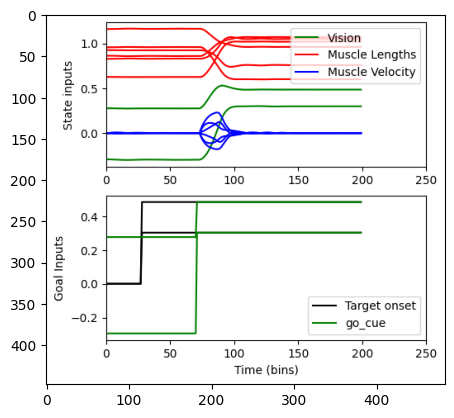

In [10]:
import matplotlib.pyplot as plt
# Show the image "image (82).png" in the current directory
img = plt.imread("image (82).png")
plt.imshow(img)


Here are the inputs to the current RandomTargetDelay task:
Top panel shows the env_states
- Visual inputs of the hand position
- Muscle lengths
- Muscle Velocities

Bottom panel shows the "inputs":
- Target onset is when the reaching target is shown to the model
- Go-cue is when the model is allowed to make the reach.

## By modifying the effector's "generate_dataset" function and the loss function, you should be able to make your model do most things without too much trouble.